In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import math
from io import StringIO

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline

from ai_backend.app.vae_model import VAE, load_model

In [2]:
MODEL_ID_KEY = "model_id"
AMOUNT_ID = "paper_amount"
LATENT_SPACE_VALUE_ID = "latent space weight"
TEST_DATA_KEY = "test_data"
PREDICTED_DATA_KEY = "predict_data"
MSE_KEY = "mse"

vae = VAE(768, 256, 3)

In [3]:
def predict_coord (vae_model, embedding) :
    embedding = np.array(embedding).astype(np.float32)
    normalizer = MinMaxScaler()
    embedding_normalized = torch.from_numpy(
        normalizer.fit_transform(embedding.reshape(-1, 1)).reshape(1, -1).flatten()
    )
    reconstructed_data, mu, logvar = vae_model(embedding_normalized)
    return mu.detach().numpy().tolist()

In [4]:
def predict_coords (vae_model, X_test):
    y_predict = pd.DataFrame()
    
    for index, embedding in X_test.iterrows():
        coord = predict_coord(vae_model, embedding.to_numpy())
        coord_data = pd.DataFrame([coord])
        y_predict = pd.concat([y_predict, coord_data], ignore_index=True)
    
    return y_predict

In [5]:
models = os.listdir("./vae_models/")
models.remove(".DS_Store")

In [6]:
def convert_string_to_number(s):
    s = s.replace(',', '.')
    if 'k' in s:
        return math.ceil(float(s.replace('k', '')) * 1000)
    else:
        return math.ceil(float(s))

In [7]:
evaluation_data = pd.DataFrame(columns=[
    MODEL_ID_KEY,
    AMOUNT_ID,
    LATENT_SPACE_VALUE_ID,
    TEST_DATA_KEY,
    PREDICTED_DATA_KEY,
    MSE_KEY,
])

for model_id in models:
    path = "./vae_models/" + model_id
    amount = model_id.split("_")[0]
    latent_weight = model_id.split("_")[1].split("-")[1]
    
    vae_model = load_model(vae, path=path)
    X_test = pd.read_csv(path + "/test_embeddings.csv", index_col=0)
    y_predict = predict_coords(vae_model, X_test)
    
    y_test = pd.read_csv(path + "/test_coordinates.csv", index_col=0)
    
    mse = mean_absolute_error(y_test, y_predict)
    
    evaluation = pd.DataFrame({
            MODEL_ID_KEY: model_id,
            AMOUNT_ID: convert_string_to_number(amount),
            LATENT_SPACE_VALUE_ID: int(latent_weight),
            TEST_DATA_KEY: y_test.to_csv(),
            PREDICTED_DATA_KEY: y_predict.to_csv(),
            MSE_KEY: mse,
        }, index=[0])
    evaluation_data = pd.concat([evaluation_data, evaluation], ignore_index=True)

/var/folders/b4/1q41jy2j1tg64llhkv024jr80000gn/T/ipykernel_26117/3281622922.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation_data = pd.concat([evaluation_data, evaluation], ignore_index=True)


In [8]:
evaluation_data = evaluation_data.sort_values(by=[AMOUNT_ID, LATENT_SPACE_VALUE_ID], ascending=[False, True])
evaluation_data.head(20)

model_id paper_amount latent space weight  \
7    50k_latent-0_model        50000                   0   
23   50k_latent-1_model        50000                   1   
5    50k_latent-2_model        50000                   2   
15   50k_latent-4_model        50000                   4   
51   50k_latent-8_model        50000                   8   
34  50k_latent-16_model        50000                  16   
32   40k_latent-0_model        40000                   0   
3    40k_latent-1_model        40000                   1   
21   40k_latent-2_model        40000                   2   
33   40k_latent-4_model        40000                   4   
44   40k_latent-8_model        40000                   8   
28  40k_latent-16_model        40000                  16   
47   30k_latent-0_model        30000                   0   
55   30k_latent-1_model        30000                   1   
45   30k_latent-2_model        30000                   2   
42   30k_latent-4_model        30000                   4   
35   30k_latent-8_model        30000                   8   
1   30k_latent-16_model        30000                  16   
59   20k_latent-0_model        20000                   0   
46   20k_latent-1_model        20000                   1   

                                            test_data  \
7   ,0,1,2\n0,-10.040573120117188,10.6885271072387...   
23  ,0,1,2\n0,-9.662853240966797,17.29533767700195...   
5   ,0,1,2\n0,19.858753204345703,17.22648811340332...   
15  ,0,1,2\n0,7.887148857116699,10.107504844665527...   
51  ,0,1,2\n0,7.938978672027588,16.53338050842285,...   
34  ,0,1,2\n0,-40.89854431152344,15.15347766876220...   
32  ,0,1,2\n0,-27.102556228637695,15.4781856536865...   
3   ,0,1,2\n0,45.503658294677734,19.77015876770019...   
21  ,0,1,2\n0,15.51707649230957,12.661321640014648...   
33  ,0,1,2\n0,-68.65430450439453,12.74538421630859...   
44  ,0,1,2\n0,23.863704681396484,16.41000747680664...   
28  ,0,1,2\n0,18.278179168701172,18.22373962402344...   
47  ,0,1,2\n0,6.761018753051758,15.590523719787598...   
55  ,0,1,2\n0,-24.597017288208008,8.59955596923828...   
45  ,0,1,2\n0,46.298851013183594,15.56896686553955...   
42  ,0,1,2\n0,35.853145599365234,16.70338439941406...   
35  ,0,1,2\n0,-70.0040283203125,12.119516372680664...   
1   ,0,1,2\n0,-3.0984995365142822,16.9830284118652...   
59  ,0,1,2\n0,8.433857917785645,18.342300415039062...   
46  ,0,1,2\n0,26.617374420166016,8.325668334960938...   

                                         predict_data        mse  
7   ,0,1,2\n0,-8.13742371974513e-05,-0.00046308775...  21.779260  
23  ,0,1,2\n0,11.921258926391602,11.33721542358398...  17.753276  
5   ,0,1,2\n0,4.075410842895508,14.862348556518555...  16.816832  
15  ,0,1,2\n0,28.341705322265625,9.96950912475586,...  16.287371  
51  ,0,1,2\n0,-33.34894943237305,17.94292831420898...  17.726464  
34  ,0,1,2\n0,6.916236877441406,12.968127250671387...  16.844314  
32  ,0,1,2\n0,-0.0004131572786718607,-4.5832712203...  22.758772  
3   ,0,1,2\n0,34.8613395690918,12.904154777526855,...  17.358221  
21  ,0,1,2\n0,-0.43251916766166687,13.246201515197...  16.298199  
33  ,0,1,2\n0,2.8450729846954346,14.36775588989257...  16.492382  
44  ,0,1,2\n0,31.10150718688965,14.215156555175781...  16.973884  
28  ,0,1,2\n0,5.973235130310059,15.269344329833984...  17.287167  
47  ,0,1,2\n0,0.0005503445863723755,-0.00061083398...  22.901787  
55  ,0,1,2\n0,4.009095191955566,9.939621925354004,...  16.127237  
45  ,0,1,2\n0,13.825784683227539,11.59577465057373...  16.798514  
42  ,0,1,2\n0,-15.436393737792969,11.8713769912719...  16.353179  
35  ,0,1,2\n0,-5.1022562980651855,10.6465501785278...  15.895018  
1   ,0,1,2\n0,-36.52898025512695,20.00676918029785...  16.082321  
59  ,0,1,2\n0,0.0018414445221424103,-0.00211619772...  23.392499  
46  ,0,1,2\n0,3.8727004528045654,5.743429660797119...  16.760216

In [9]:
evaluation_data.describe()

mse
count  60.000000
mean   18.846127
std     4.579148
min    13.814897
25%    15.819290
50%    16.821219
75%    21.704138
max    32.904686

In [10]:
def display_diffenrence(data, figsize_columns, figsize = (15, 15)):
    figsize_rows = math.ceil(len(data) / figsize_columns)
    fig, ax = plt.subplots(figsize_rows, figsize_columns, figsize=figsize)
    fig.tight_layout(pad=4)

    for i in range(len(data)):
        plt.subplot(figsize_rows, figsize_columns, i+1).set_title(f"latent_weight: {data.iloc[i][LATENT_SPACE_VALUE_ID]}")
        
        y_test = pd.read_csv(StringIO(data.iloc[i][TEST_DATA_KEY]), index_col=0)
        y_predict = pd.read_csv(StringIO(data.iloc[i][PREDICTED_DATA_KEY]), index_col=0)

        plt.subplot(figsize_rows, figsize_columns, i+1).scatter(
            y_test["0"],
            y_predict["0"],
            color="blue",
            alpha=0.15,
            label='x'
            )
        plt.subplot(figsize_rows, figsize_columns, i+1).scatter(
            y_test["2"],
            y_predict["2"],
            color="green",
            alpha=0.15,
            label='z'
            )
        plt.subplot(figsize_rows, figsize_columns, i+1).scatter(
            y_test["1"],
            y_predict["1"],
            color="red",
            alpha=0.15,
            label='y'
            )
        
        
        plt.subplot(figsize_rows, figsize_columns, i+1).set_xlabel("True values")
        plt.subplot(figsize_rows, figsize_columns, i+1).set_ylabel("Predicted values")
        plt.xlim([-100.5, 100.5])
        plt.ylim([-100.5, 100.5])
        plt.legend()
    
    return fig

In [11]:
unique_paper_amounts = evaluation_data[AMOUNT_ID].unique()

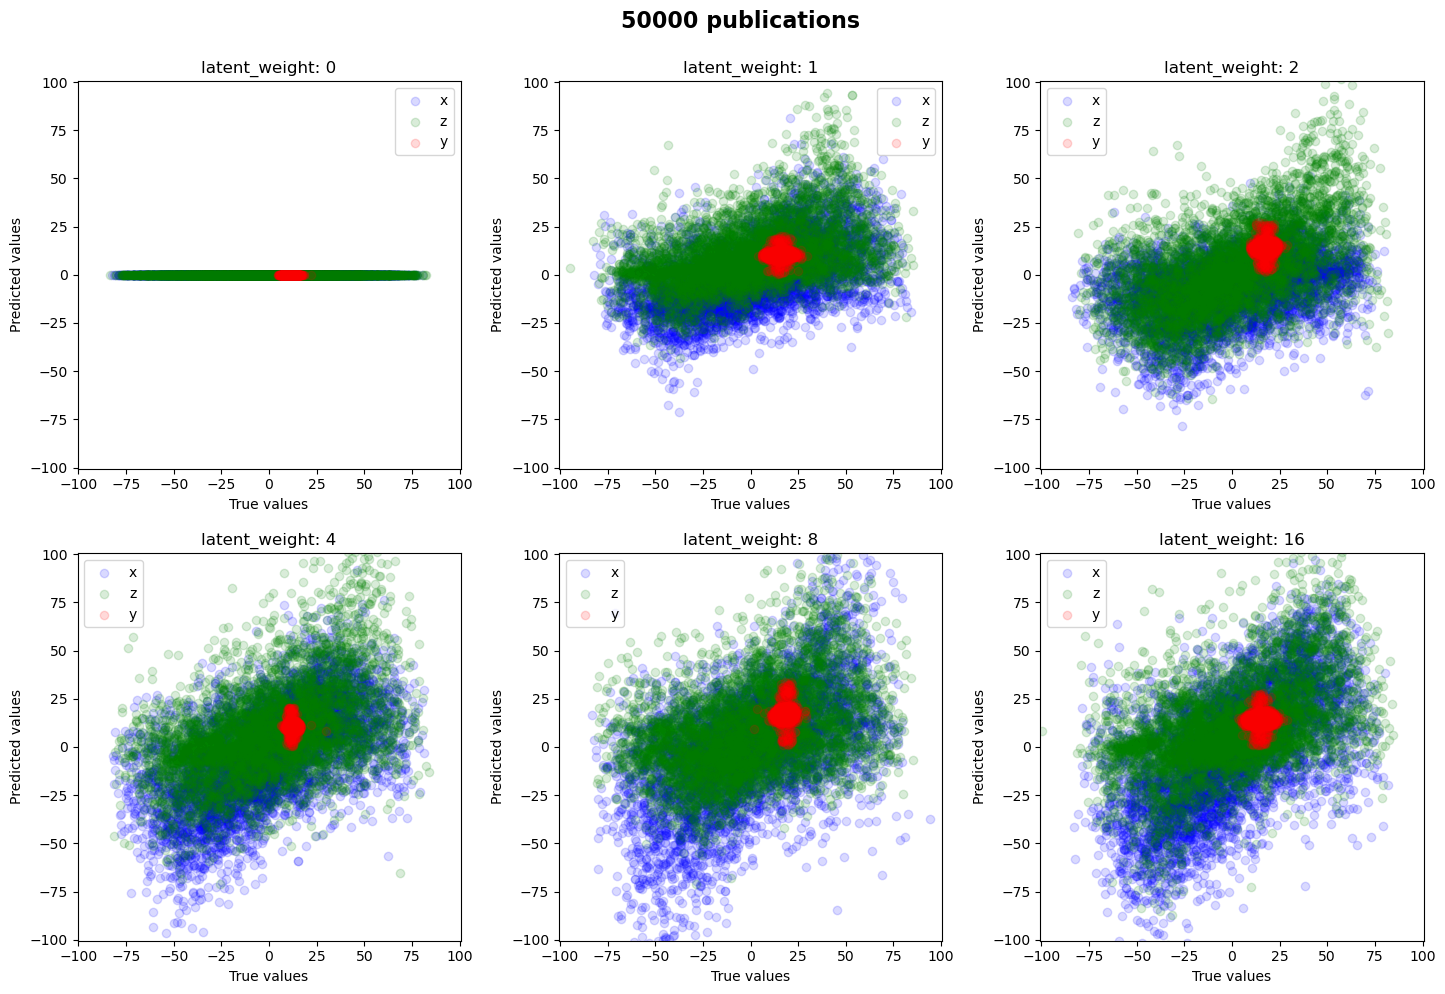

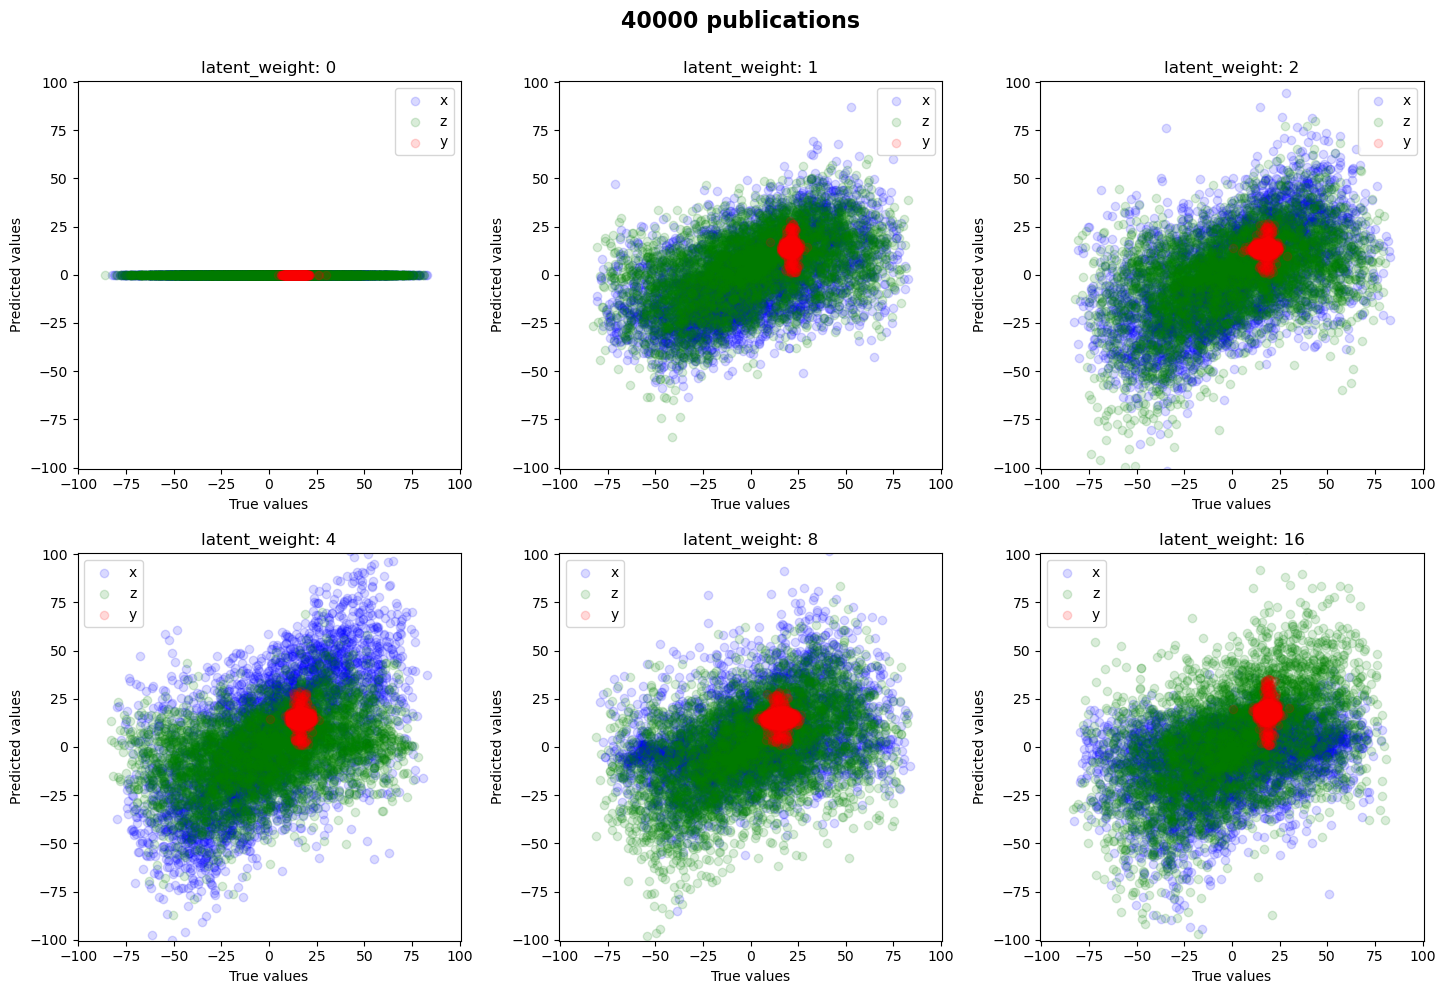

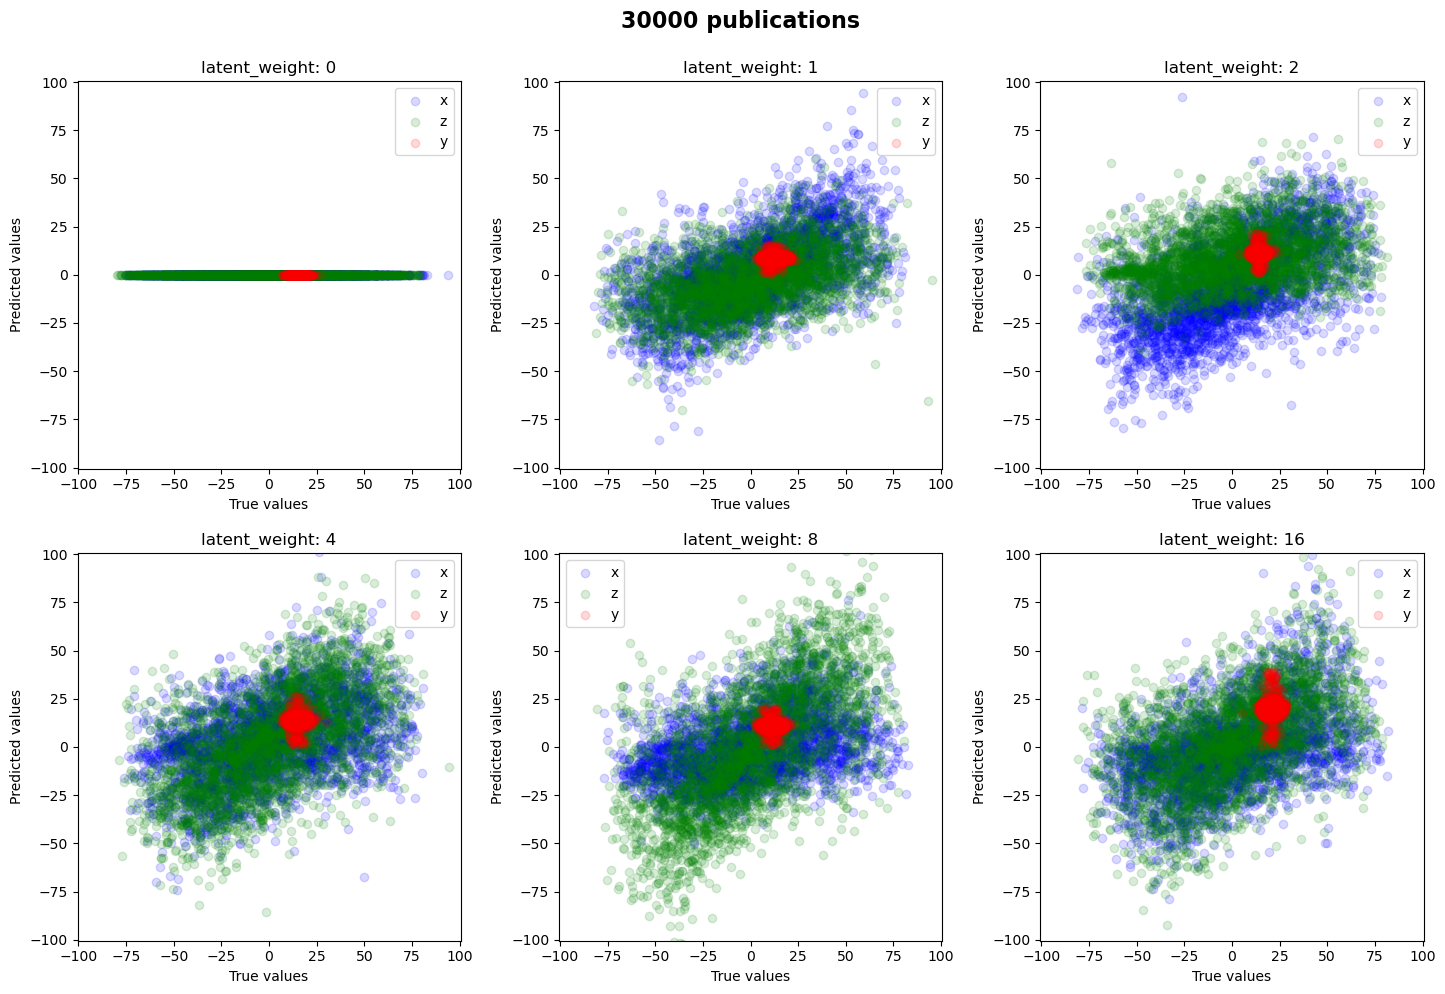

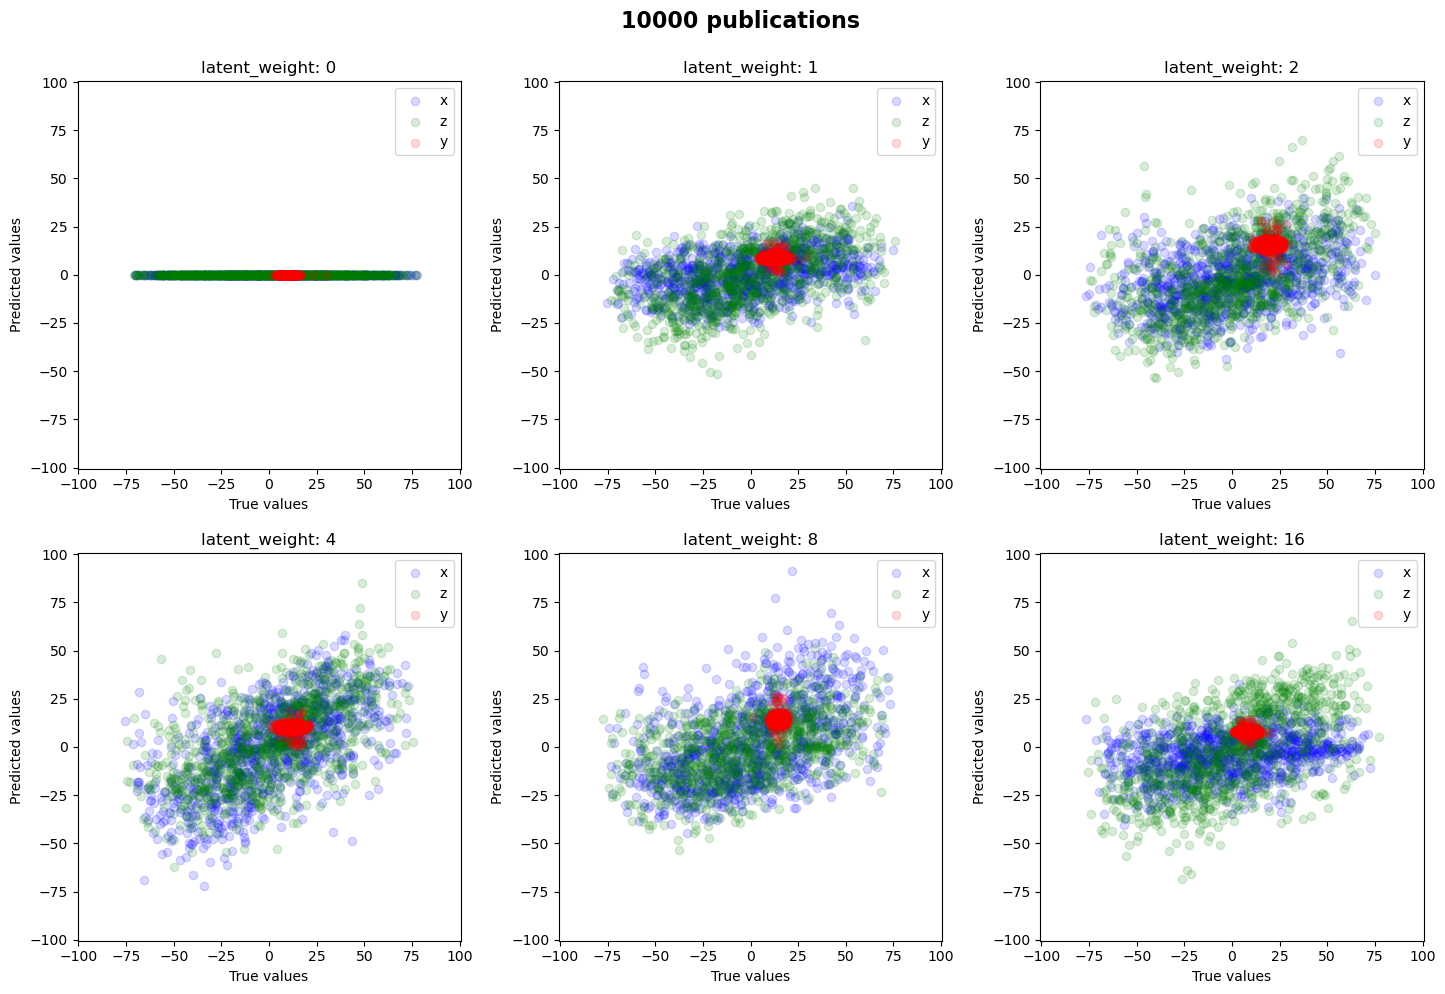

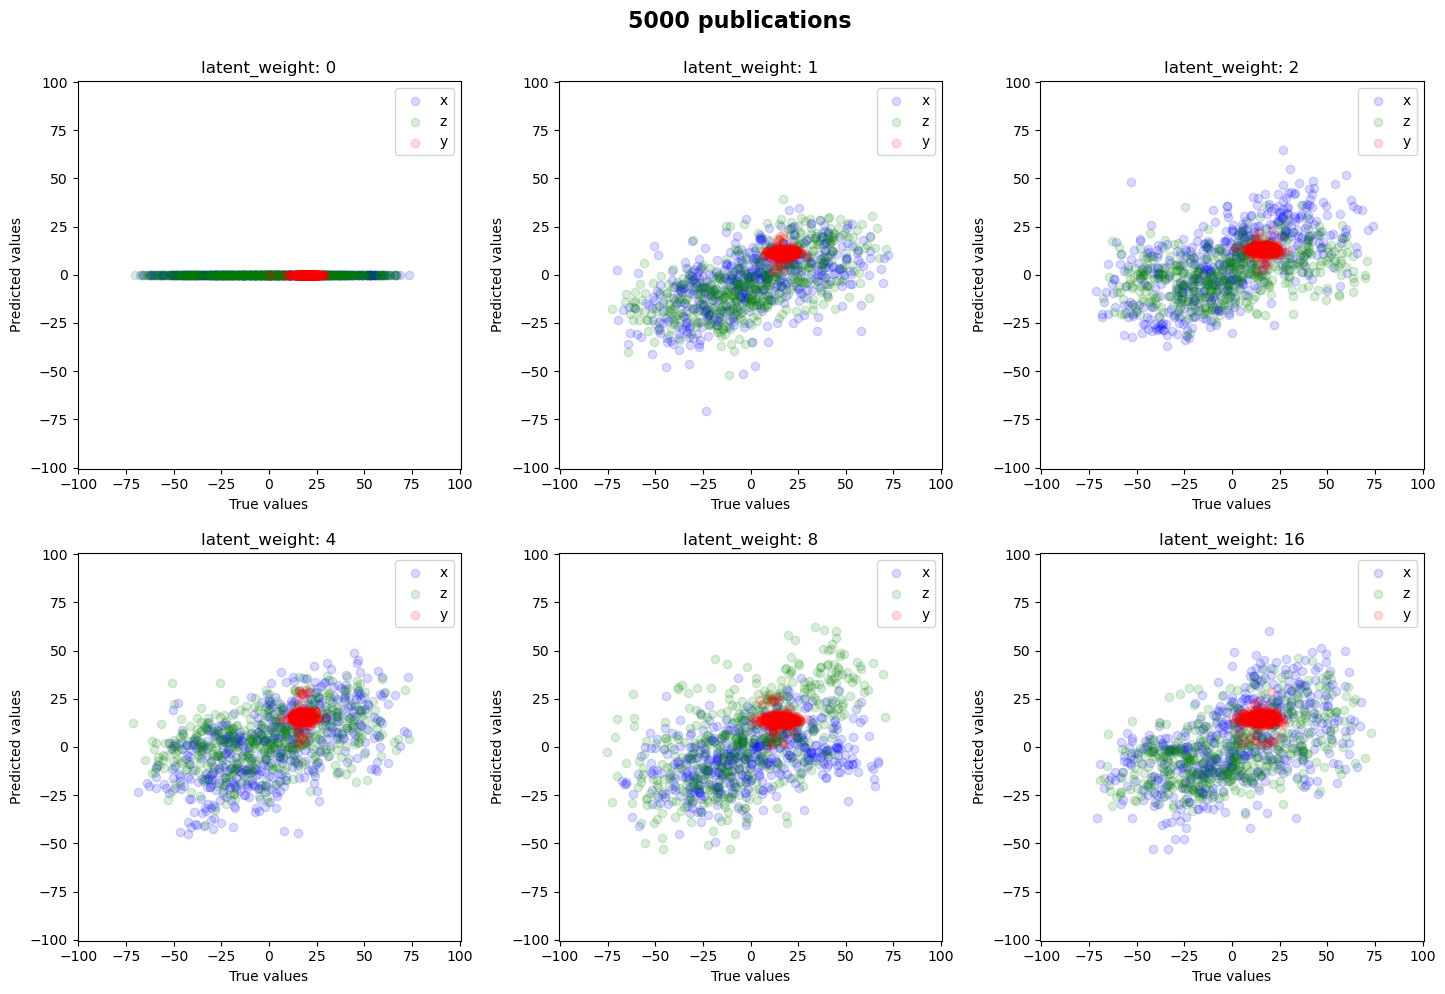

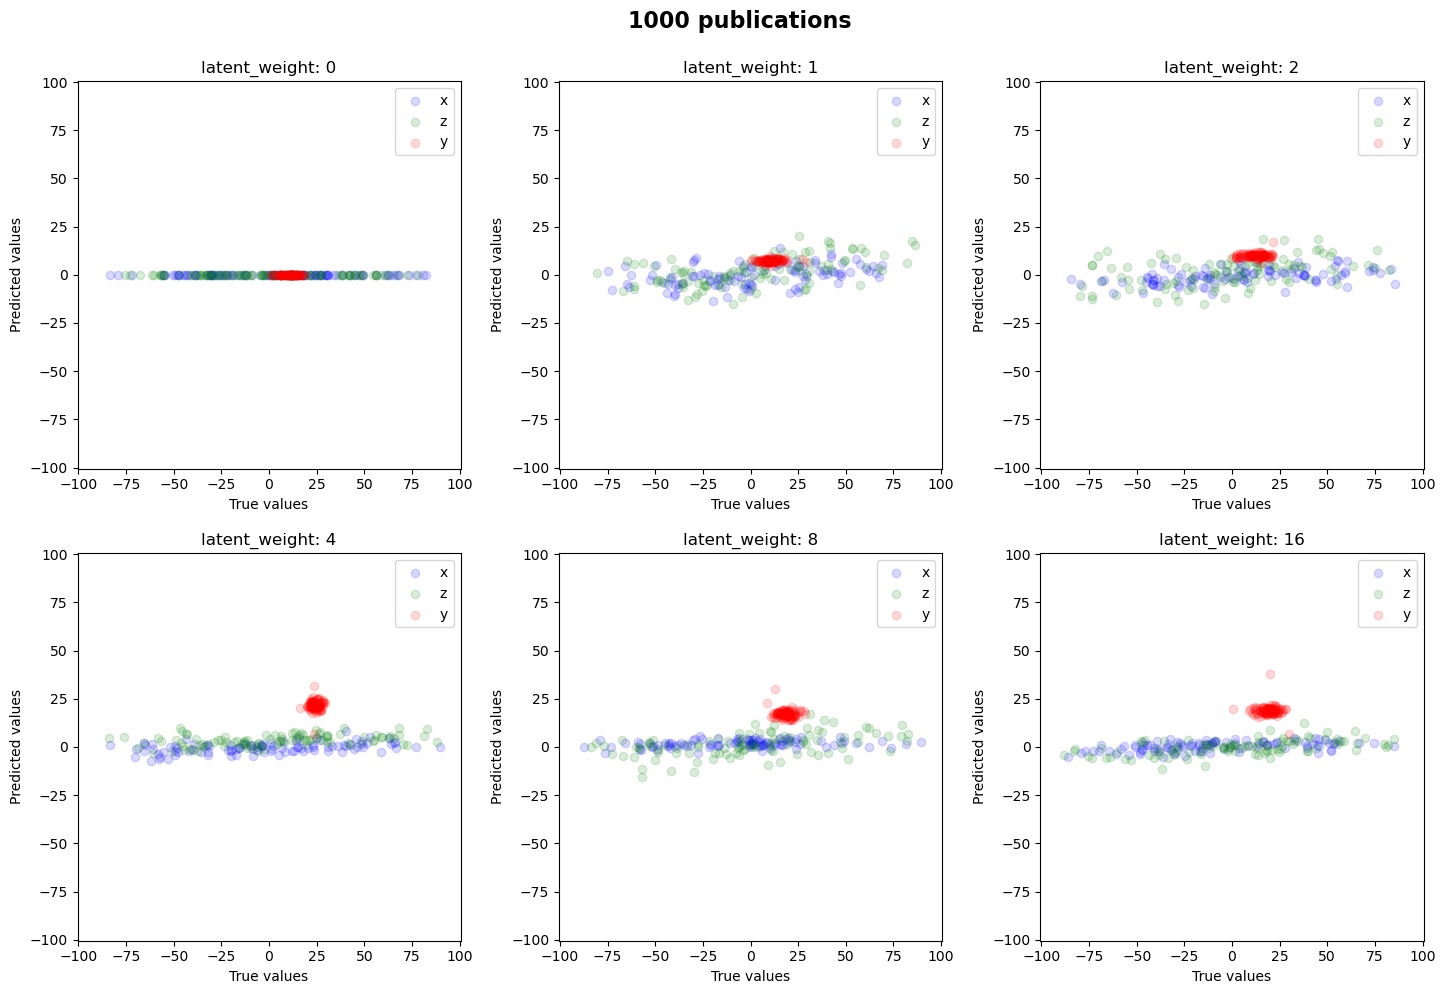

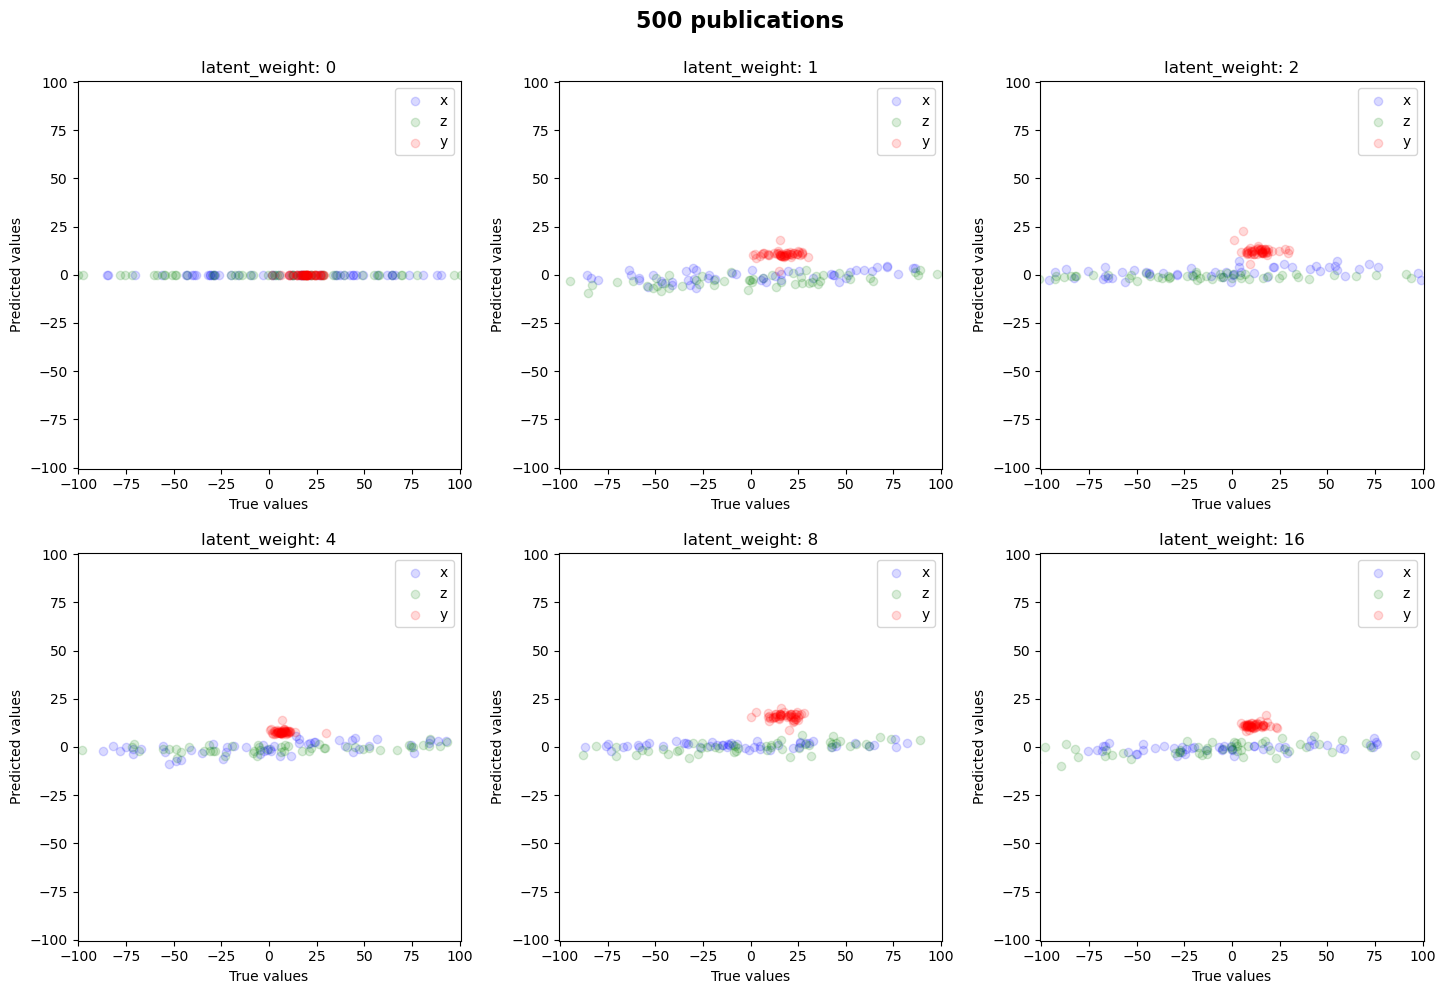

In [12]:
for amnount in unique_paper_amounts:
    data = evaluation_data[evaluation_data[AMOUNT_ID] == amnount]
    fig = display_diffenrence(data, 3, (15, 10))
    fig.suptitle(f"{amnount} publications", fontsize=16, fontweight='bold', y=1.01)

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))

for paper_amount in unique_paper_amounts:
    filtered_df = evaluation_data[evaluation_data[AMOUNT_ID] == paper_amount]
    
    x = filtered_df[LATENT_SPACE_VALUE_ID].values
    y = filtered_df[MSE_KEY].values
    
    spl = make_interp_spline(x, y, k=2)  
    
    x_new = np.linspace(x.min(), x.max(), 500)
    y_new = spl(x_new)
    
    ax.plot(x_new, y_new, label=f'{paper_amount} Publications', linestyle='-')
    ax.scatter(x, y, zorder=5, s=50)

ax.set_title('MSE for Different Publication Amounts')
ax.set_xlabel('Latent Space Weight')
ax.set_ylabel('MSE')
ax.legend()

plt.show()